# 1. IMPORT LIBRARY

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. PREPARING DATA

In [2]:
#import data
data = pd.read_csv('ab_test.csv')
df=data.copy()
df.head(10)

,user_id,timestamp,team,landing_page,converted,year,month,day,week,weekday
0,847050,2017-01-21 02:17:34,treatment,new_page,0,2017,1,21,3,7
1,743950,2017-01-17 13:20:30,control,old_page,0,2017,1,17,3,3
2,850772,2017-01-08 01:15:08,treatment,new_page,0,2017,1,8,2,1
3,685456,2017-01-21 10:07:05,treatment,new_page,0,2017,1,21,3,7
4,697362,2017-01-18 20:37:55,control,old_page,1,2017,1,18,3,4
5,697942,2017-01-17 20:38:35,treatment,new_page,0,2017,1,17,3,3
6,822190,2017-01-06 09:16:02,control,old_page,0,2017,1,6,1,6
7,796364,2017-01-23 21:53:38,treatment,new_page,0,2017,1,23,4,2
8,897719,2017-01-06 06:44:26,control,old_page,0,2017,1,6,1,6
9,878065,2017-01-05 03:13:19,treatment,new_page,0,2017,1,5,1,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   team          294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   year          294478 non-null  int64 
 6   month         294478 non-null  int64 
 7   day           294478 non-null  int64 
 8   week          294478 non-null  int64 
 9   weekday       294478 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 22.5+ MB


There are 10 features and 294,478 entries
- user_id: contains user ids
- timestamp, year, month, day, week, weekday: is about when a session was
- team: contains 2 variables: control and treatment
- landing_page: is about what version of a site a user saw
- converted: says us about user's behavior: if a user made a purchase (1) or not (0)

In [4]:
team = df.team.unique()
page = df.landing_page.unique()
year = df.year.unique()
month = df.month.unique()
day_max = df.day.max()
day_min = df.day.min()
week = df.week.unique()
team, page, year, month, day_max, day_min, week

(array(['treatment', 'control'], dtype=object),
 array(['new_page', 'old_page'], dtype=object),
 array([2017], dtype=int64),
 array([1], dtype=int64),
 24,
 2,
 array([3, 2, 1, 4], dtype=int64))

The experiment launched in Jan, 2017, during 4 weeks, 23 days, from 2nd to 24th.
There were 2 groups treatment and control, experience old and new page to check the percentage of purchase to consideer shouldwe run new version

In [5]:
pd.crosstab(df.team, df.converted)

converted,0,1
team,,
control,129479,17723
treatment,129762,17514


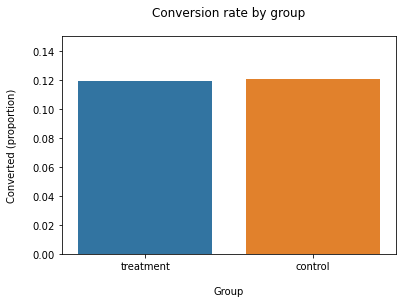

In [11]:
sns.barplot(x=df['team'], y=df['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [6]:
sum_Ncont = len(df.query('team == "control"'))
sum_Nexp = len(df.query('team == "treatment"'))
sum_Xcont= 17723
sum_Xexp= 17514
print('Total control group sum_Ncont: {0:d}\nTotal treatment group sum_Nexp: {1:d}\nNumber of purchase in control group sum_Xcont: {2:d}\nNumber of purchase in treatment group sum_Xexp: {3:d}'.format(sum_Ncont, sum_Nexp, sum_Xcont, sum_Xexp))

Total control group sum_Ncont: 147202
Total treatment group sum_Nexp: 147276
Number of purchase in control group sum_Xcont: 17723
Number of purchase in treatment group sum_Xexp: 17514


# 3. HYPOTHESIS

Hypothesis:
+ H0: pexp - pcont = 0 -> no launch new version
+ H1: pexp - pcont > 0 -> lanunch new version

# 4. DATA ANALYSIS

## 4.1. Sanity check

In [7]:
# import sanity_check file (by week, weekday and day)
sanity_check= pd.read_csv('sanity_check.csv')
sanity_check.sort_values(by= 'day')

,week,weekday,day,Xcont,Ncont,Xexp,Nexp
2,1,2,2,362,2894,348,2889
19,1,3,3,760,6684,762,6710
0,1,4,4,810,6655,773,6629
10,1,5,5,801,6538,758,6586
7,1,6,6,778,6684,848,6844
1,1,7,7,805,6678,776,6703
15,2,1,8,805,6769,821,6795
14,2,2,9,806,6725,794,6714
3,2,3,10,763,6745,858,6778
11,2,4,11,808,6787,785,6766


There are 2 methods to check whether the experiment is correct: p value and probability per day

### 4.1.1. P value method

In [8]:
# Check p value
# use confidence interval 1-alpha= 95%,
alpha= 0.05
# probability across groups
p=(sum_Xexp+sum_Xcont)/(sum_Nexp+sum_Ncont)
# Compute standard deviation with p
SD=math.sqrt(p*(1-p)/(sum_Ncont+sum_Nexp))
# Margin of error: z-score=1.96
z=1.96
m=SD*1.96
# Cconfidence interval around p
upper=p+m
lower=p-m
# Check whether obsered factor within interval
pexp= sum_Xexp/(sum_Nexp+sum_Ncont)
print('alpha: {0:,f}\nprobability p: {1:,f}\nSD: {2:,f}\nm: {3:,f}\nconfidence interval: ({4:,f},{5:,f})'.format(alpha, p, SD, m, lower, upper))

alpha: 0.050000
probability p: 0.119659
SD: 0.000598
m: 0.001172
confidence interval: (0.118487,0.120831)


We can see that p within interval, so the experiment is correct

### 4.1.2. Probability per day

In [9]:
# check probability control group per day
check_pcont=sanity_check[['day', 'Ncont', 'Nexp']].copy()
pcont=check_pcont.Ncont/(check_pcont.Ncont+check_pcont.Nexp)
pcont

0     0.500979
1     0.499066
2     0.500432
3     0.498780
4     0.505572
5     0.502266
6     0.496547
7     0.494086
8     0.502035
9     0.495145
10    0.498171
11    0.500775
12    0.494736
13    0.497281
14    0.500409
15    0.499042
16    0.502252
17    0.501463
18    0.501392
19    0.499029
20    0.506283
21    0.497787
22    0.506345
dtype: float64

I found that p is run smoothly, so there is no wrong in this experiment

## 4.2. Data analysis

After passing sanity check, I process to analyze to compare two groups.

In [10]:
alpha= 0.05 #significance level 1-alpha ~ 95%
beta= 0.2 #statistical power 1-beta ~ 80%
z=1.96 #z-score
p #probability across groups
d= sum_Xexp/sum_Nexp - sum_Xcont/sum_Ncont #difference probability between groups
SE=math.sqrt(p*(1-p)*(1/sum_Ncont + 1/sum_Nexp)) #standard error
m=z*SE #margin error
upper= d+m
lower= d-m
print('d: {2:,f}\nconfidence interval: ({0:,f},{1:,f})'.format(lower, upper,d))

d: -0.001480
confidence interval: (-0.003824,0.000865)


I found that d is within confidence interval, so Ho would be accepted, I recommend that we should not launched the new version